In [1]:
import sys, torch, os, json
print(f"pytorch version: {torch.__version__}")
import numpy as np
from tqdm import tqdm

module_rootdir = '.'
dataset_rootdir = '.'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

trained_weights_path = './model_weights/gnn/1715232829109/graph_based_detector.pt'
config_file_path = './configuration_radarscenes_gnn.yml'

from modules.set_configurations.set_config_gnn import config
from modules.data_utils.read_data import get_train_val_sequence_names
from modules.set_configurations.set_param_for_inference_gnn import set_parameters_for_inference
from modules.data_utils.read_data import get_sequence_data
from modules.data_utils.labels import compute_new_labels_to_id_dict
from modules.data_utils.labels import compute_old_to_new_label_id_map
from modules.performance.detection_accuracy import compute_gt_and_pred_objects, compute_gt_and_pred_associations

save_model_performance_root_dir = './performance/object_classification'
os.makedirs(save_model_performance_root_dir, exist_ok=True)

pytorch version: 2.0.1


In [2]:
config_obj = config(config_file_path)
train_sequence_names, test_sequence_names = get_train_val_sequence_names(dataset_rootdir, config_obj.dataset_path)

print('train sequences')
print(train_sequence_names)
print('validation sequences')
print(test_sequence_names)

train sequences
['sequence_1', 'sequence_2', 'sequence_3', 'sequence_4', 'sequence_7', 'sequence_8', 'sequence_9', 'sequence_10', 'sequence_11', 'sequence_12', 'sequence_13', 'sequence_15', 'sequence_16', 'sequence_17', 'sequence_18', 'sequence_20', 'sequence_21', 'sequence_22', 'sequence_23', 'sequence_25', 'sequence_26', 'sequence_27', 'sequence_28', 'sequence_29', 'sequence_30', 'sequence_32', 'sequence_33', 'sequence_34', 'sequence_35', 'sequence_36', 'sequence_37', 'sequence_38', 'sequence_39', 'sequence_40', 'sequence_41', 'sequence_43', 'sequence_44', 'sequence_45', 'sequence_46', 'sequence_47', 'sequence_49', 'sequence_50', 'sequence_51', 'sequence_52', 'sequence_54', 'sequence_55', 'sequence_56', 'sequence_57', 'sequence_59', 'sequence_60', 'sequence_61', 'sequence_62', 'sequence_64', 'sequence_65', 'sequence_66', 'sequence_67', 'sequence_69', 'sequence_70', 'sequence_71', 'sequence_72', 'sequence_74', 'sequence_75', 'sequence_76', 'sequence_77', 'sequence_78', 'sequence_80', 

In [3]:
clustering_eps = 1.5

param_obj = set_parameters_for_inference(module_rootdir, config_obj, trained_weights_path)
device = param_obj['device']
grid = param_obj['grid']
detector = param_obj['detector']
detector.set_param_for_proposal_extraction(clustering_eps) 

labels_to_id_dict = compute_new_labels_to_id_dict()
old_to_new_label_id_map = compute_old_to_new_label_id_map()

cluster_size_threshold = 2

pred_gt_association_eps = 1.0

CLASS_NAMES = ['CAR', 'PEDESTRIAN', 'PEDESTRIAN_GROUP', 'TWO_WHEELER', 'LARGE_VEHICLE', 'NONE', 'FALSE']

GPU is available. Good to go!


In [4]:
all_sequence_names = test_sequence_names + train_sequence_names

for sequence_name in all_sequence_names:

    scene_metadata, radar_mount_data, radar_data_all_scenes, odometry_data_all_scenes \
            = get_sequence_data(dataset_rootdir, config_obj.dataset_path, sequence_name, config_obj.window_size)

    print(f"processing {sequence_name} with {len(scene_metadata)} number of frames")

    gt_count_matrix = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
    confusion_matrix = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)

    for idx in tqdm(range(len(scene_metadata))):

        gt_and_pred_objects = compute_gt_and_pred_objects(
                idx,
                scene_metadata,
                radar_mount_data,
                radar_data_all_scenes,
                odometry_data_all_scenes,
                labels_to_id_dict,
                old_to_new_label_id_map,
                grid, 
                config_obj, 
                device,
                detector,
                cluster_size_threshold)
        
        gt_pred_associations = compute_gt_and_pred_associations(gt_and_pred_objects, pred_gt_association_eps)
        obj_class_gt_associated = gt_pred_associations['obj_class_gt_associated']
        obj_class_pred_associated = gt_pred_associations['obj_class_pred_associated']
        obj_class_gt = gt_pred_associations['obj_class_gt']
        obj_class_pred = gt_pred_associations['obj_class_pred']

        if obj_class_gt.shape[0] != 0:
                for i in range(obj_class_gt.shape[0]):
                        gt_count_matrix[obj_class_gt[i]] += 1

        if obj_class_gt_associated.shape[0] != 0:
                for i in range(obj_class_gt_associated.shape[0]):
                        confusion_matrix[obj_class_gt_associated[i], obj_class_pred_associated[i]] += 1
                        
    file_name = sequence_name + '.json'
    file_name = os.path.join(save_model_performance_root_dir, file_name)

    performance_data = {}
    performance_data['class_names'] = CLASS_NAMES
    performance_data['confusion_matrix'] = confusion_matrix.tolist()
    performance_data['gt_count_matrix'] = gt_count_matrix.tolist()

    with open(file_name, 'w') as json_file:
        json.dump(performance_data, json_file, indent=4)


processing sequence_5 with 4049 number of frames


100%|██████████| 4049/4049 [00:57<00:00, 70.29it/s]


processing sequence_6 with 3726 number of frames


100%|██████████| 3726/3726 [00:57<00:00, 64.65it/s]


processing sequence_14 with 2099 number of frames


100%|██████████| 2099/2099 [01:01<00:00, 34.13it/s]


processing sequence_19 with 4593 number of frames


100%|██████████| 4593/4593 [01:10<00:00, 65.09it/s] 


processing sequence_24 with 5760 number of frames


100%|██████████| 5760/5760 [01:33<00:00, 61.84it/s] 


processing sequence_31 with 1510 number of frames


100%|██████████| 1510/1510 [00:14<00:00, 101.56it/s]


processing sequence_42 with 4412 number of frames


100%|██████████| 4412/4412 [01:37<00:00, 45.21it/s]


processing sequence_48 with 4997 number of frames


100%|██████████| 4997/4997 [02:09<00:00, 38.61it/s]


processing sequence_53 with 1501 number of frames


100%|██████████| 1501/1501 [00:33<00:00, 44.75it/s]


processing sequence_58 with 7434 number of frames


100%|██████████| 7434/7434 [01:44<00:00, 71.47it/s] 


processing sequence_63 with 4751 number of frames


100%|██████████| 4751/4751 [01:04<00:00, 73.77it/s] 


processing sequence_68 with 6102 number of frames


100%|██████████| 6102/6102 [01:33<00:00, 65.47it/s]


processing sequence_73 with 7021 number of frames


100%|██████████| 7021/7021 [02:08<00:00, 54.70it/s]


processing sequence_79 with 3680 number of frames


100%|██████████| 3680/3680 [01:38<00:00, 37.40it/s]


processing sequence_85 with 2541 number of frames


100%|██████████| 2541/2541 [01:57<00:00, 21.66it/s]


processing sequence_89 with 4351 number of frames


100%|██████████| 4351/4351 [01:54<00:00, 37.94it/s]


processing sequence_93 with 6014 number of frames


100%|██████████| 6014/6014 [03:23<00:00, 29.58it/s]


processing sequence_99 with 8837 number of frames


100%|██████████| 8837/8837 [05:44<00:00, 25.65it/s]


processing sequence_107 with 9285 number of frames


100%|██████████| 9285/9285 [06:52<00:00, 22.51it/s] 


processing sequence_111 with 1672 number of frames


100%|██████████| 1672/1672 [01:26<00:00, 19.23it/s]


processing sequence_122 with 894 number of frames


100%|██████████| 894/894 [00:11<00:00, 77.13it/s] 


processing sequence_130 with 7374 number of frames


100%|██████████| 7374/7374 [02:27<00:00, 50.10it/s] 


processing sequence_135 with 5314 number of frames


100%|██████████| 5314/5314 [01:51<00:00, 47.49it/s]


processing sequence_138 with 7753 number of frames


100%|██████████| 7753/7753 [04:31<00:00, 28.52it/s]


processing sequence_147 with 6103 number of frames


100%|██████████| 6103/6103 [03:38<00:00, 27.95it/s]


processing sequence_148 with 6002 number of frames


100%|██████████| 6002/6002 [02:32<00:00, 39.23it/s]


processing sequence_153 with 4031 number of frames


100%|██████████| 4031/4031 [00:54<00:00, 74.32it/s]


processing sequence_155 with 5884 number of frames


100%|██████████| 5884/5884 [01:26<00:00, 68.01it/s]


processing sequence_1 with 4649 number of frames


100%|██████████| 4649/4649 [02:10<00:00, 35.55it/s] 


processing sequence_2 with 7647 number of frames


100%|██████████| 7647/7647 [05:34<00:00, 22.88it/s] 


processing sequence_3 with 1656 number of frames


100%|██████████| 1656/1656 [00:35<00:00, 47.02it/s]


processing sequence_4 with 1554 number of frames


100%|██████████| 1554/1554 [00:17<00:00, 87.55it/s] 


processing sequence_7 with 6205 number of frames


100%|██████████| 6205/6205 [02:22<00:00, 43.43it/s] 


processing sequence_8 with 3960 number of frames


100%|██████████| 3960/3960 [02:46<00:00, 23.75it/s]


processing sequence_9 with 4748 number of frames


100%|██████████| 4748/4748 [02:39<00:00, 29.80it/s]


processing sequence_10 with 11524 number of frames


100%|██████████| 11524/11524 [05:45<00:00, 33.37it/s]


processing sequence_11 with 1558 number of frames


100%|██████████| 1558/1558 [00:42<00:00, 36.42it/s]


processing sequence_12 with 2348 number of frames


100%|██████████| 2348/2348 [01:07<00:00, 34.93it/s]


processing sequence_13 with 2270 number of frames


100%|██████████| 2270/2270 [00:55<00:00, 40.95it/s] 


processing sequence_15 with 1061 number of frames


100%|██████████| 1061/1061 [00:23<00:00, 45.99it/s] 


processing sequence_16 with 1059 number of frames


100%|██████████| 1059/1059 [00:22<00:00, 47.94it/s]


processing sequence_17 with 700 number of frames


100%|██████████| 700/700 [00:15<00:00, 44.37it/s]


processing sequence_18 with 971 number of frames


100%|██████████| 971/971 [00:22<00:00, 42.72it/s]


processing sequence_20 with 7860 number of frames


100%|██████████| 7860/7860 [01:46<00:00, 73.54it/s] 


processing sequence_21 with 5801 number of frames


100%|██████████| 5801/5801 [01:16<00:00, 75.84it/s] 


processing sequence_22 with 8244 number of frames


100%|██████████| 8244/8244 [01:59<00:00, 68.95it/s]


processing sequence_23 with 6812 number of frames


100%|██████████| 6812/6812 [01:49<00:00, 62.22it/s]


processing sequence_25 with 7408 number of frames


100%|██████████| 7408/7408 [01:58<00:00, 62.38it/s]


processing sequence_26 with 6368 number of frames


100%|██████████| 6368/6368 [01:44<00:00, 61.11it/s]


processing sequence_27 with 8273 number of frames


100%|██████████| 8273/8273 [02:13<00:00, 61.96it/s]


processing sequence_28 with 11362 number of frames


100%|██████████| 11362/11362 [02:55<00:00, 64.92it/s]


processing sequence_29 with 7003 number of frames


100%|██████████| 7003/7003 [01:54<00:00, 61.34it/s]


processing sequence_30 with 4317 number of frames


100%|██████████| 4317/4317 [01:06<00:00, 64.83it/s]


processing sequence_32 with 6366 number of frames


100%|██████████| 6366/6366 [01:02<00:00, 102.16it/s]


processing sequence_33 with 7051 number of frames


100%|██████████| 7051/7051 [01:20<00:00, 87.07it/s] 


processing sequence_34 with 5048 number of frames


100%|██████████| 5048/5048 [00:34<00:00, 147.92it/s] 


processing sequence_35 with 725 number of frames


100%|██████████| 725/725 [00:15<00:00, 46.50it/s]


processing sequence_36 with 1810 number of frames


100%|██████████| 1810/1810 [00:47<00:00, 38.43it/s]


processing sequence_37 with 4980 number of frames


100%|██████████| 4980/4980 [01:21<00:00, 61.08it/s]


processing sequence_38 with 3015 number of frames


100%|██████████| 3015/3015 [01:03<00:00, 47.41it/s]


processing sequence_39 with 3872 number of frames


100%|██████████| 3872/3872 [01:01<00:00, 63.02it/s]


processing sequence_40 with 2992 number of frames


100%|██████████| 2992/2992 [01:00<00:00, 49.17it/s]


processing sequence_41 with 4617 number of frames


100%|██████████| 4617/4617 [01:49<00:00, 42.01it/s]


processing sequence_43 with 5932 number of frames


100%|██████████| 5932/5932 [01:43<00:00, 57.36it/s]


processing sequence_44 with 4515 number of frames


100%|██████████| 4515/4515 [01:20<00:00, 56.30it/s]


processing sequence_45 with 6989 number of frames


100%|██████████| 6989/6989 [02:47<00:00, 41.81it/s]


processing sequence_46 with 4785 number of frames


100%|██████████| 4785/4785 [01:19<00:00, 60.10it/s]


processing sequence_47 with 4810 number of frames


100%|██████████| 4810/4810 [01:11<00:00, 67.36it/s]


processing sequence_49 with 1586 number of frames


100%|██████████| 1586/1586 [00:21<00:00, 74.21it/s]


processing sequence_50 with 1042 number of frames


100%|██████████| 1042/1042 [00:16<00:00, 64.28it/s]


processing sequence_51 with 1879 number of frames


100%|██████████| 1879/1879 [00:42<00:00, 43.88it/s]


processing sequence_52 with 1563 number of frames


100%|██████████| 1563/1563 [00:34<00:00, 44.93it/s]


processing sequence_54 with 966 number of frames


100%|██████████| 966/966 [00:18<00:00, 53.22it/s]


processing sequence_55 with 1402 number of frames


100%|██████████| 1402/1402 [00:29<00:00, 47.68it/s]


processing sequence_56 with 4810 number of frames


100%|██████████| 4810/4810 [02:08<00:00, 37.45it/s]


processing sequence_57 with 4758 number of frames


100%|██████████| 4758/4758 [02:12<00:00, 35.94it/s]


processing sequence_59 with 2575 number of frames


100%|██████████| 2575/2575 [00:58<00:00, 44.23it/s]


processing sequence_60 with 13841 number of frames


100%|██████████| 13841/13841 [06:10<00:00, 37.36it/s]


processing sequence_61 with 3948 number of frames


100%|██████████| 3948/3948 [01:42<00:00, 38.67it/s]


processing sequence_62 with 6556 number of frames


100%|██████████| 6556/6556 [01:30<00:00, 72.72it/s]


processing sequence_64 with 6754 number of frames


100%|██████████| 6754/6754 [02:47<00:00, 40.35it/s]


processing sequence_65 with 6694 number of frames


100%|██████████| 6694/6694 [02:19<00:00, 47.85it/s]


processing sequence_66 with 4974 number of frames


100%|██████████| 4974/4974 [01:20<00:00, 62.12it/s]


processing sequence_67 with 7797 number of frames


100%|██████████| 7797/7797 [03:12<00:00, 40.44it/s]


processing sequence_69 with 9500 number of frames


100%|██████████| 9500/9500 [03:32<00:00, 44.61it/s]


processing sequence_70 with 7713 number of frames


100%|██████████| 7713/7713 [01:56<00:00, 66.10it/s]


processing sequence_71 with 5289 number of frames


100%|██████████| 5289/5289 [01:12<00:00, 73.09it/s]


processing sequence_72 with 7047 number of frames


100%|██████████| 7047/7047 [02:34<00:00, 45.67it/s]


processing sequence_74 with 5607 number of frames


100%|██████████| 5607/5607 [01:31<00:00, 61.46it/s]


processing sequence_75 with 4489 number of frames


100%|██████████| 4489/4489 [01:45<00:00, 42.53it/s]


processing sequence_76 with 3712 number of frames


100%|██████████| 3712/3712 [02:39<00:00, 23.32it/s]


processing sequence_77 with 4296 number of frames


100%|██████████| 4296/4296 [02:04<00:00, 34.55it/s]


processing sequence_78 with 1362 number of frames


100%|██████████| 1362/1362 [00:32<00:00, 41.90it/s]


processing sequence_80 with 4875 number of frames


100%|██████████| 4875/4875 [03:02<00:00, 26.77it/s]


processing sequence_81 with 738 number of frames


100%|██████████| 738/738 [00:15<00:00, 46.93it/s]


processing sequence_82 with 4196 number of frames


100%|██████████| 4196/4196 [00:47<00:00, 88.42it/s] 


processing sequence_83 with 1576 number of frames


100%|██████████| 1576/1576 [00:49<00:00, 31.57it/s]


processing sequence_84 with 4200 number of frames


100%|██████████| 4200/4200 [02:34<00:00, 27.25it/s]


processing sequence_86 with 2433 number of frames


100%|██████████| 2433/2433 [01:52<00:00, 21.55it/s]


processing sequence_87 with 6064 number of frames


100%|██████████| 6064/6064 [03:24<00:00, 29.61it/s]


processing sequence_88 with 7007 number of frames


100%|██████████| 7007/7007 [03:56<00:00, 29.66it/s]


processing sequence_90 with 1489 number of frames


100%|██████████| 1489/1489 [00:37<00:00, 39.76it/s]


processing sequence_91 with 6297 number of frames


100%|██████████| 6297/6297 [02:59<00:00, 35.08it/s]


processing sequence_92 with 1979 number of frames


100%|██████████| 1979/1979 [00:46<00:00, 42.32it/s]


processing sequence_94 with 8751 number of frames


100%|██████████| 8751/8751 [04:14<00:00, 34.39it/s]


processing sequence_95 with 5630 number of frames


100%|██████████| 5630/5630 [03:06<00:00, 30.20it/s]


processing sequence_96 with 1059 number of frames


100%|██████████| 1059/1059 [00:27<00:00, 39.12it/s]


processing sequence_97 with 8513 number of frames


100%|██████████| 8513/8513 [03:41<00:00, 38.46it/s]


processing sequence_98 with 6244 number of frames


100%|██████████| 6244/6244 [03:10<00:00, 32.74it/s]


processing sequence_100 with 7130 number of frames


100%|██████████| 7130/7130 [02:53<00:00, 41.03it/s]


processing sequence_101 with 7210 number of frames


100%|██████████| 7210/7210 [03:03<00:00, 39.34it/s]


processing sequence_102 with 6061 number of frames


100%|██████████| 6061/6061 [02:54<00:00, 34.80it/s]


processing sequence_103 with 2044 number of frames


100%|██████████| 2044/2044 [00:27<00:00, 74.27it/s]


processing sequence_104 with 6980 number of frames


100%|██████████| 6980/6980 [04:00<00:00, 28.98it/s]


processing sequence_105 with 6469 number of frames


100%|██████████| 6469/6469 [05:39<00:00, 19.04it/s]


processing sequence_106 with 6120 number of frames


100%|██████████| 6120/6120 [04:13<00:00, 24.19it/s]


processing sequence_108 with 8088 number of frames


100%|██████████| 8088/8088 [04:06<00:00, 32.86it/s]


processing sequence_109 with 9801 number of frames


100%|██████████| 9801/9801 [04:59<00:00, 32.73it/s]


processing sequence_110 with 9268 number of frames


100%|██████████| 9268/9268 [10:05<00:00, 15.32it/s]


processing sequence_112 with 10032 number of frames


100%|██████████| 10032/10032 [04:54<00:00, 34.12it/s]


processing sequence_113 with 10804 number of frames


100%|██████████| 10804/10804 [08:17<00:00, 21.70it/s]


processing sequence_114 with 4486 number of frames


100%|██████████| 4486/4486 [02:41<00:00, 27.82it/s] 


processing sequence_115 with 8416 number of frames


100%|██████████| 8416/8416 [04:15<00:00, 32.96it/s] 


processing sequence_116 with 1197 number of frames


100%|██████████| 1197/1197 [00:25<00:00, 47.83it/s] 


processing sequence_117 with 13147 number of frames


100%|██████████| 13147/13147 [07:41<00:00, 28.51it/s]


processing sequence_118 with 11132 number of frames


100%|██████████| 11132/11132 [05:04<00:00, 36.59it/s]


processing sequence_119 with 6797 number of frames


100%|██████████| 6797/6797 [03:27<00:00, 32.73it/s]


processing sequence_120 with 2897 number of frames


100%|██████████| 2897/2897 [01:56<00:00, 24.79it/s]


processing sequence_121 with 1215 number of frames


100%|██████████| 1215/1215 [00:41<00:00, 29.46it/s]


processing sequence_123 with 3104 number of frames


100%|██████████| 3104/3104 [01:26<00:00, 35.91it/s]


processing sequence_124 with 7045 number of frames


100%|██████████| 7045/7045 [02:27<00:00, 47.88it/s] 


processing sequence_125 with 4562 number of frames


100%|██████████| 4562/4562 [04:03<00:00, 18.77it/s]


processing sequence_126 with 7240 number of frames


100%|██████████| 7240/7240 [06:23<00:00, 18.88it/s]


processing sequence_127 with 6892 number of frames


100%|██████████| 6892/6892 [03:19<00:00, 34.53it/s]


processing sequence_128 with 8139 number of frames


100%|██████████| 8139/8139 [03:23<00:00, 40.01it/s]


processing sequence_129 with 6345 number of frames


100%|██████████| 6345/6345 [03:09<00:00, 33.41it/s]


processing sequence_131 with 2953 number of frames


100%|██████████| 2953/2953 [02:54<00:00, 16.97it/s]


processing sequence_132 with 5987 number of frames


100%|██████████| 5987/5987 [05:28<00:00, 18.21it/s]


processing sequence_133 with 7417 number of frames


100%|██████████| 7417/7417 [02:49<00:00, 43.75it/s] 


processing sequence_134 with 5136 number of frames


100%|██████████| 5136/5136 [02:47<00:00, 30.74it/s]


processing sequence_136 with 2474 number of frames


100%|██████████| 2474/2474 [00:24<00:00, 100.70it/s] 


processing sequence_137 with 7283 number of frames


100%|██████████| 7283/7283 [03:19<00:00, 36.48it/s]


processing sequence_139 with 4529 number of frames


100%|██████████| 4529/4529 [02:08<00:00, 35.36it/s]


processing sequence_140 with 8626 number of frames


100%|██████████| 8626/8626 [08:25<00:00, 17.08it/s]


processing sequence_141 with 4317 number of frames


100%|██████████| 4317/4317 [02:47<00:00, 25.79it/s]


processing sequence_142 with 9843 number of frames


100%|██████████| 9843/9843 [06:21<00:00, 25.78it/s] 


processing sequence_143 with 3579 number of frames


100%|██████████| 3579/3579 [01:48<00:00, 33.11it/s]


processing sequence_144 with 7368 number of frames


100%|██████████| 7368/7368 [03:58<00:00, 30.86it/s]


processing sequence_145 with 4820 number of frames


100%|██████████| 4820/4820 [02:57<00:00, 27.12it/s]


processing sequence_146 with 8110 number of frames


100%|██████████| 8110/8110 [04:41<00:00, 28.81it/s]


processing sequence_149 with 15332 number of frames


100%|██████████| 15332/15332 [03:24<00:00, 75.00it/s]


processing sequence_150 with 2717 number of frames


100%|██████████| 2717/2717 [00:35<00:00, 77.45it/s]


processing sequence_151 with 3682 number of frames


100%|██████████| 3682/3682 [00:50<00:00, 73.21it/s]


processing sequence_152 with 5122 number of frames


100%|██████████| 5122/5122 [01:05<00:00, 78.02it/s]


processing sequence_154 with 5632 number of frames


100%|██████████| 5632/5632 [01:10<00:00, 80.35it/s]


processing sequence_156 with 5153 number of frames


100%|██████████| 5153/5153 [01:18<00:00, 65.54it/s]


processing sequence_157 with 6138 number of frames


100%|██████████| 6138/6138 [01:22<00:00, 74.11it/s] 


processing sequence_158 with 795 number of frames


100%|██████████| 795/795 [00:10<00:00, 78.55it/s]


## Test Dataset

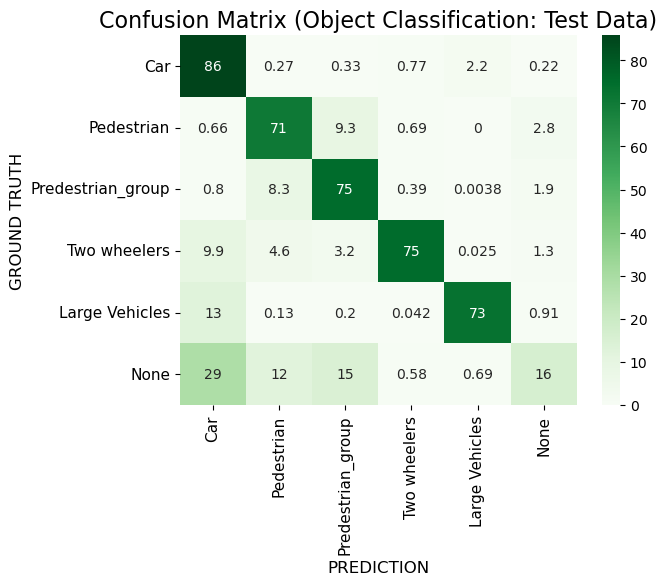

[[85.73  0.27  0.33  0.77  2.17  0.22]
 [ 0.66 70.52  9.3   0.69  0.    2.81]
 [ 0.8   8.27 75.16  0.39  0.    1.94]
 [ 9.89  4.62  3.21 75.05  0.02  1.33]
 [12.54  0.13  0.2   0.04 73.23  0.91]
 [28.67 12.32 14.75  0.58  0.69 16.27]]


In [5]:
gt_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
confusion_matrix_sum = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)

for sequence_name in test_sequence_names:

    file_path = os.path.join(save_model_performance_root_dir, sequence_name + '.json')
    with open(file_path, 'r') as file:
        performance = json.load(file)

    confusion_matrix_sum += np.array(performance['confusion_matrix'], dtype=np.uint64)
    gt_count_matrix_sum += np.array(performance['gt_count_matrix'], dtype=np.uint64)


detection_rates = np.zeros(confusion_matrix_sum.shape, dtype=np.float32)
for i in range(gt_count_matrix_sum.shape[0]):
    num_gt = gt_count_matrix_sum[i]
    if num_gt > 0: detection_rates[i, :] = confusion_matrix_sum[i, :] / num_gt * 100
    else: detection_rates[i, :] = 0.0

import seaborn as sns
import matplotlib.pyplot as plt

CLASS_NAMES = ['Car', 'Pedestrian', 'Predestrian_group', 'Two wheelers', 'Large Vehicles', 'None']
hmap = sns.heatmap(data=detection_rates[:-1, :-1], annot=True, cmap='Greens')
hmap.set_title('Confusion Matrix (Object Classification: Test Data)', size=16)
hmap.set_xlabel('PREDICTION', size=12)
hmap.set_ylabel('GROUND TRUTH', size=12)
hmap.xaxis.set_ticklabels(CLASS_NAMES, rotation=90, size=11)
hmap.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, size=11)
fig = hmap.get_figure()
plt.show()

np.set_printoptions(suppress=True, precision=2)
print(detection_rates[:-1, :-1])

## Train Dataset

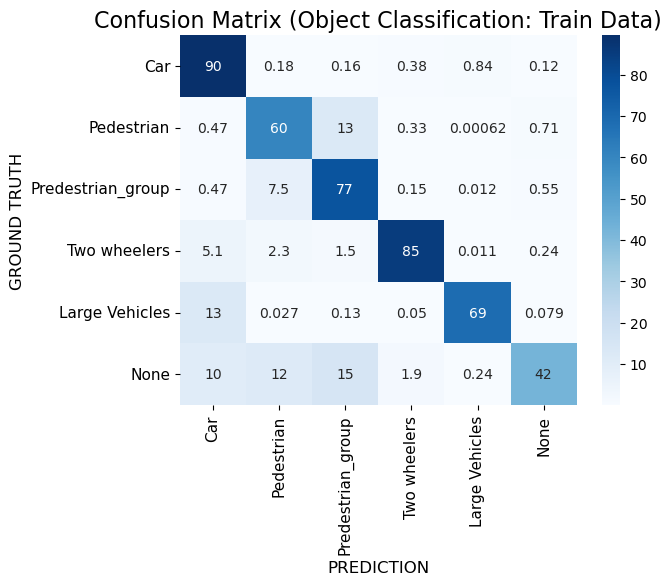

[[89.51  0.18  0.16  0.38  0.84  0.12]
 [ 0.47 60.18 12.91  0.33  0.    0.71]
 [ 0.47  7.51 77.22  0.15  0.01  0.55]
 [ 5.13  2.28  1.48 85.21  0.01  0.24]
 [12.85  0.03  0.13  0.05 68.58  0.08]
 [10.36 11.68 15.27  1.89  0.24 42.42]]


In [6]:
gt_count_matrix_sum = np.zeros((config_obj.num_classes, ), dtype=np.uint64)
confusion_matrix_sum = np.zeros((config_obj.num_classes, config_obj.num_classes), dtype=np.uint64)

for sequence_name in train_sequence_names:

    file_path = os.path.join(save_model_performance_root_dir, sequence_name + '.json')
    with open(file_path, 'r') as file:
        performance = json.load(file)

    confusion_matrix_sum += np.array(performance['confusion_matrix'], dtype=np.uint64)
    gt_count_matrix_sum += np.array(performance['gt_count_matrix'], dtype=np.uint64)


detection_rates = np.zeros(confusion_matrix_sum.shape, dtype=np.float32)
for i in range(gt_count_matrix_sum.shape[0]):
    num_gt = gt_count_matrix_sum[i]
    if num_gt > 0: detection_rates[i, :] = confusion_matrix_sum[i, :] / num_gt * 100
    else: detection_rates[i, :] = 0.0

import seaborn as sns
import matplotlib.pyplot as plt

CLASS_NAMES = ['Car', 'Pedestrian', 'Predestrian_group', 'Two wheelers', 'Large Vehicles', 'None']
hmap = sns.heatmap(data=detection_rates[:-1, :-1], annot=True, cmap='Blues')
hmap.set_title('Confusion Matrix (Object Classification: Train Data)', size=16)
hmap.set_xlabel('PREDICTION', size=12)
hmap.set_ylabel('GROUND TRUTH', size=12)
hmap.xaxis.set_ticklabels(CLASS_NAMES, rotation=90, size=11)
hmap.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, size=11)
fig = hmap.get_figure()
plt.show()

np.set_printoptions(suppress=True, precision=2)
print(detection_rates[:-1, :-1])